# Model template using multiple polygons
This is an exercise to test the computing time for fitting and predicting spatial models using an assortment of different polygons.

This can work as a general template for other models and data pipelines.

In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()

#import traversals.strategies as st
#from os import walk
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import pymc3 as pm

## Use the ggplot style
plt.style.use('ggplot')

/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from external_plugins.spystats.spystats import utilities as ut

In [5]:
bursera_path = '/outputs/presence_only_models/data/burseras'
bursera_dataset = ut.loadDataset(bursera_path)

train_path = '/outputs/presence_only_models/data/root'
train_dataset = ut.loadDataset(train_path)
## Predictors
pred_path = '/outputs/presence_only_models/predictors/datasetp2'
pred_dataset = ut.loadDataset(pred_path)
### PATCH, the thing is taking backwards the order of the lists of files, because of the name
#pred_dataset.reverse()

INFO:external_plugins.spystats.spystats.utilities:Reading file /outputs/presence_only_models/data/burseras
INFO:external_plugins.spystats.spystats.utilities:Reading file /outputs/presence_only_models/data/root
INFO:external_plugins.spystats.spystats.utilities:Reading file /outputs/presence_only_models/predictors/datasetp2


In [6]:
## Recreating the polygons
## This should be included in the data structure
from django.contrib.gis.geos import Point, Polygon
xcoord = -99.76
ycoord = 17.55
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,1, 10)
polys = map(lambda r : p.buffer(r),radii)


## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [7]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


In [8]:
prediction_dataset_dic= map(lambda p : ut.preparePredictors(p),pred_dataset)


### Ok, lets start the ,modelling here

In [10]:
#pm.traceplot(trace)
from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh

In [11]:
## This is for calculating the signal
from pymc3.variational.callbacks import CheckParametersConvergence
def FitMyModel(Y,train,predictor):
    #
    with pm.Model() as model:

        ## [R | Y]

        tau = pm.HalfNormal('tau',sd=10)
        sigma = pm.HalfNormal('sigma',sd=10)
        phi = pm.Uniform('phi',0,15)

        Tau = pm.gp.cov.Constant(tau)
        cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1])) + Tau

        ## Parameters for linear predictor
        #b0 = pm.Normal('b0',mu=0,sd=10)
        b = pm.Normal('b',mu=0,sd=10,shape=3)
        mf = pm.gp.mean.Linear(coeffs=[b]) 

        ## The latent function
        gp = pm.gp.Latent(cov_func=cov)
        f = gp.prior("latent_field", X=train[['Longitude','Latitude','DistanceToRoadMex_mean','WorldPopLatam2010_mean','vegid']].values,reparameterize=False)


        ## Other model M2

        beta_y = pm.Normal("betay",mu=0, sd=10,shape=2)

        theta = beta_y[0] + beta_y[1] * train.MaxTemperature_mean.values

        yy = pm.Bernoulli("yy",logit_p=theta,observed=Y.values)


        #y_obs = pm.Bernoulli('y_obs',logit_p=(f*yy),observed=Y.values)


        trace = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
        #trace = pm.sample(10)
        trace = trace.sample(draws=5000)


        f_star = gp.conditional("f_star", predictor['clean'][['Longitude','Latitude','Dist.to.road_m','Population_m','covid']].values)

        pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)
        return pred_samples
   

In [13]:
i = 4

datatrain = train_dataset[i]
#Y = datatrain.Burseraceae
Y = datatrain.Burseraceae
datapred = prediction_dataset_dic[i]
polygon = polys[i]

elevation = RasterData(rastermodelinstance=ETOPO1,border=polygon)
height = 100
width = 100
### Remember that the geoparams are not necesarily the same as the template.
## This is why it's important to import this object as well
elevation.resize(width,height)
#elevation.display_field(origin='Lower',interpolation='None')
%time pred_samples = FitMyModel(Y,datatrain,datapred)
ut.plotThings(pred_samples)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 518.85: 100%|██████████| 15000/15000 [03:47<00:00, 66.01it/s]
Finished [100%]: Average Loss = 518.47
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 518.47
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.5--2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.5--2.7.11-64/lock_dir/lock
100%|██████████| 100/100 [11:28<00:00,  6.89s/it]


CPU times: user 39min 39s, sys: 1min 14s, total: 40min 53s
Wall time: 16min 2s


NameError: global name 'datapred' is not defined

In [ ]:

for i in range(len(prediction_dataset_dic)):
    datatrain = train_dataset[i]
    #Y = datatrain.Burseraceae
    Y = datatrain.Burseraceae
    datapred = prediction_dataset_dic[i]
    polygon = polys[i]

    elevation = RasterData(rastermodelinstance=ETOPO1,border=polygon)
    height = 100
    width = 100
    ### Remember that the geoparams are not necesarily the same as the template.
    ## This is why it's important to import this object as well
    elevation.resize(width,height)
    #elevation.display_field(origin='Lower',interpolation='None')
    %time pred_samples = FitMyModel(Y,datatrain,datapred)
    ut.plotThings(pred_samples)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.5--2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.5--2.7.11-64/lock_dir/lock
Average Loss = 44.29: 100%|██████████| 15000/15000 [01:14<00:00, 202.21it/s]
Finished [100%]: Average Loss = 44.276
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 44.276
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.5--2.7.11-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /root/.theano/compiledir_Linux-3.16--amd64-x86_64-with-debian-8.5--2.7.11-64/lock_dir/lock
  4%|▍         | 4/100 [00:26<10:24,  6.50s/it]

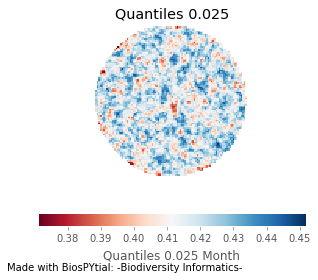

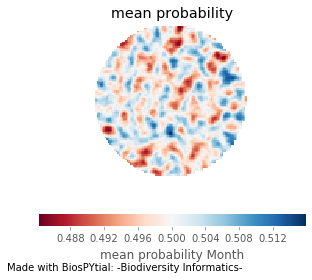

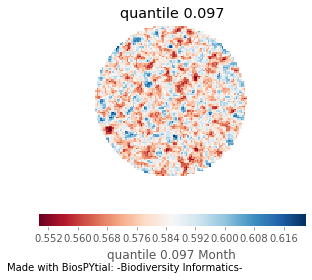

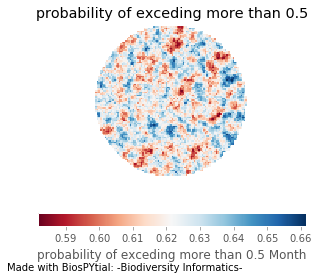

In [25]:
ut.plotThings(pred_samples,datapred,elevation)

In [ ]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
expit(ql_presences_of_something.rasterdata.bands[0].data())
plt.imshow(ql_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens)
plt.title("Presences quantile 0.025")
plt.colorbar(orientation='horizontal')

In [ ]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(mean_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens,clim=(0,1))

plt.colorbar(orientation='horizontal')
plt.title('Probability of presences (mean surface)' )

In [ ]:
from scipy.special import expit
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(qh_presences_of_something.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.Greens,clim=(0,1))
plt.colorbar(orientation='horizontal')
plt.title("Presences quantile 0.975")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(prob5.rasterdata.bands[1].data(),origin='Lower',cmap=plt.cm.RdBu,clim=(0,1))
plt.colorbar(orientation='horizontal')
plt.title("Probability of probability more than 0.5 of presence of Burseracea family")

## Export results to GEotif!

In [ ]:
name = "sample_root"
ql_presences_of_something.exportToGeoTiff("ql_"+name)


In [ ]:
mean_presences_of_something.exportToGeoTiff("mean_"+name)

In [ ]:
qh_presences_of_something.exportToGeoTiff("qh_"+name)

In [ ]:
prob5.exportToGeoTiff("prob05"+name)